# Data Analysis Interview Challenge

## Part 1 ‐ Exploratory data analysis

The attached *logins.json* file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time
import seaborn as sns
from pandas import Timestamp
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
# Let's take a look at the data
df_logs = pd.read_json('logins.json')
df_logs

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [5]:
df_logs.describe()

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [6]:
# Check data info
df_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
# Use assign to count the logins
df_logs.set_index('login_time', inplace=True)
df_logs = df_logs.assign(login_counts=1)
df_logs

,login_counts
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


In [8]:
df_15 = df_logs.resample('15min').sum()
df_15

,login_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [9]:
df_15['month'] = df_15.index.month
df_15['day_of_week'] = df_15.index.dayofweek
df_15['hour'] = df_15.index.hour
df_15['day'] = df_15.index.day
df_15

,login_counts,month,day_of_week,hour,day
login_time,,,,,
1970-01-01 20:00:00,2,1,3,20,1
1970-01-01 20:15:00,6,1,3,20,1
1970-01-01 20:30:00,9,1,3,20,1
1970-01-01 20:45:00,7,1,3,20,1
1970-01-01 21:00:00,1,1,3,21,1
...,...,...,...,...,...
1970-04-13 17:45:00,5,4,0,17,13
1970-04-13 18:00:00,5,4,0,18,13
1970-04-13 18:15:00,2,4,0,18,13


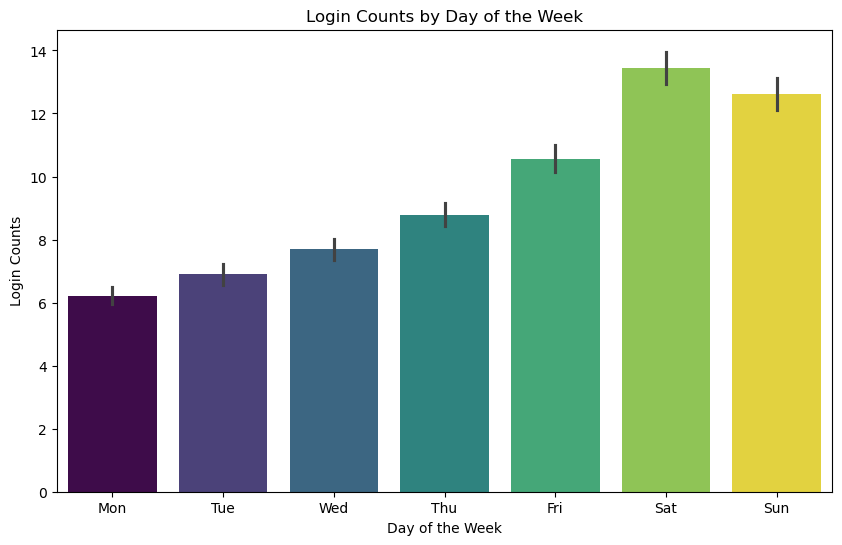

In [10]:
# Plot the logins by the week
plt.figure(figsize=(10,6))
sns.barplot(x='day_of_week', y='login_counts', data=df_15, palette='viridis', hue='day_of_week', legend=False)
plt.title('Login Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Login Counts')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

**The number of logins during the week increased as it reached Saturday and decreased on Sunday.**

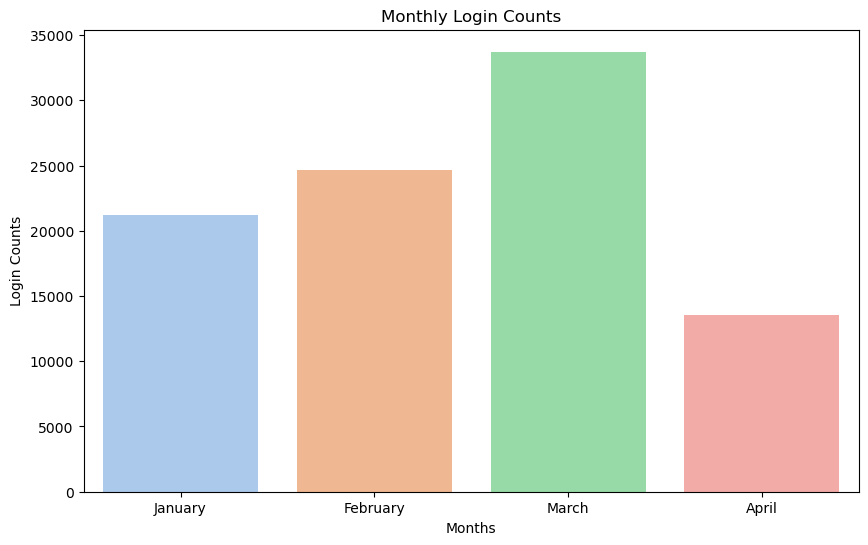

In [12]:
# Plot the logins by Month
monthly_logs = df_15.groupby('month')['login_counts'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='month', y='login_counts', data=monthly_logs, palette='pastel', hue='month', legend=False)
plt.title('Monthly Login Counts')
plt.xlabel('Months')
plt.ylabel('Login Counts')
plt.xticks(ticks=range(4), labels=['January', 'February', 'March', 'April'])
plt.show()

April has the lowest amount of logins in comparison to the other months, while March has the highest login counts. Could the reason for the large amount of logins for March be due to Spring Break?

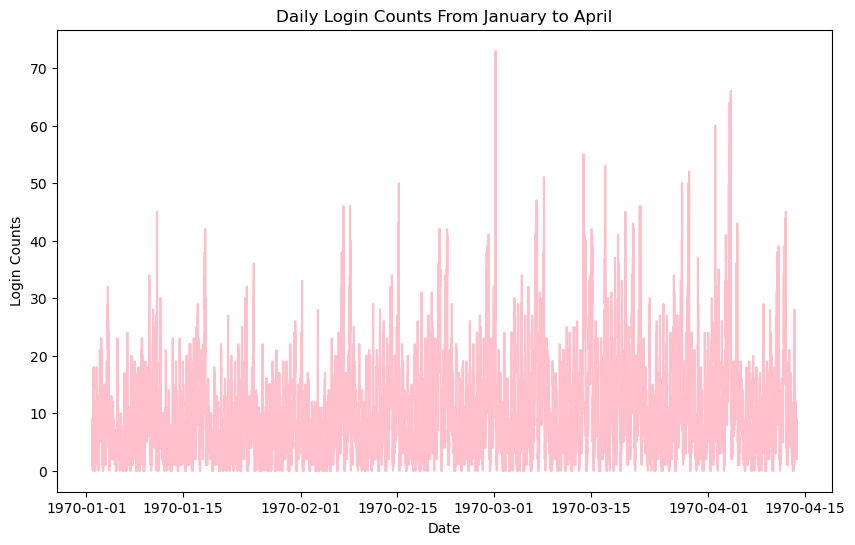

In [14]:
daily_logs = df_15.groupby('login_time').sum().reset_index()

plt.figure(figsize=(10,6))
plt.plot(df_15['login_counts'], data=daily_logs, color='pink')
plt.title('Daily Login Counts From January to April')
plt.xlabel('Date')
plt.ylabel('Login Counts')
plt.show()

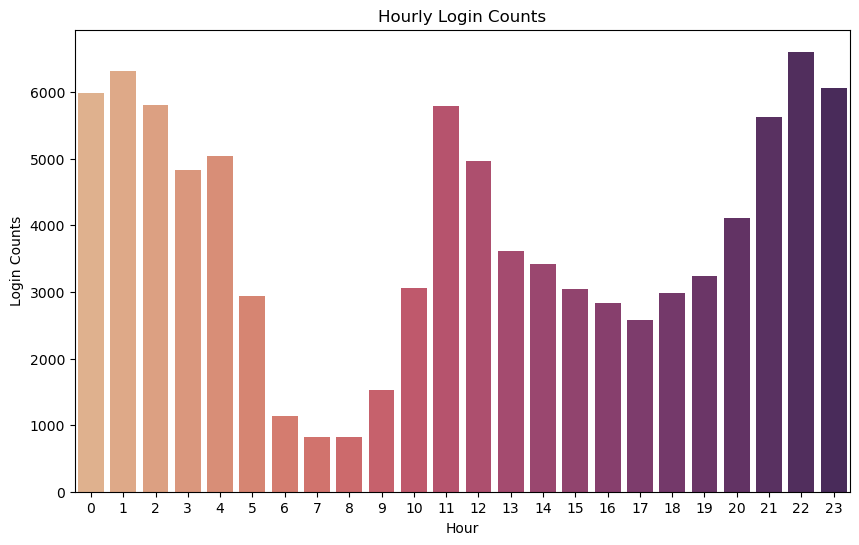

In [15]:
# Plot the logins by Hour
hourly_logs = df_15.groupby('hour')['login_counts'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='hour', y='login_counts', data=hourly_logs, palette='flare', hue='hour', legend=False)
plt.title('Hourly Login Counts')
plt.xlabel('Hour')
plt.ylabel('Login Counts')
plt.show()

Based on the data, the least amount of logins occurs during the hours of 7:00 and 8:00 AM.

# Findings:
* The login counts were at an increasing rate from January to March, with a decline in April.
* The most login day is Saturday, with Monday having the least amount of logins.
* The majority of logins occur at 11:00 PM, while the least amount of logins occur around 7:00-8:00 AM.
* The date that had the most login was recorded on March 1st, 1970.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the
observation
c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### Question 1 Solution:

The key measure of success for this experiment is an increase in toll reimbursement. A rise in reimbursements indicates that more drivers are serving both cities, which can lead to enhanced ride availability during peak times in each location, benefiting both the drivers as well as boosting overall revenue for both citites. Measuring how many drivers continue to operate both cities over time can provide insights into the long-term viability of the reimbursement program and its impact on driver retention.

### Question 2 Solution:

a. **Implementation of the Experiment**
To implement the experiment, I will need to collect a sample of driver partners from both Gotham and Metropolis, ensuring a mix of those who primarily drive in one city and those who occasionally drive in both. I would also need to track the number of trips made by the drivers in both cities, specifically noting any trips that involve crossing the toll bridge. In addition, I will need the toll reimbursement record to measure the financial incentive's uptake. A collection of data where ride availability and average wait times in both cities during peak hours would also be benificial.

b. **Statistical Tests**
Since I will be comparing examples from before and after the experiment, I will use t-tests. I could also use a Chi-square test to analyze the categorical data related to the frequency of drivers serving both cities. I could also implement a regression analysis to control for potential confounding variables that could potentially affect trip frequency.

c. **Interpreting the Results and Recommendations**
If there is a significant increase in the number of trips made in both cities compared to the control group, it indicates that the toll reimbursement effectively encouraged driver partners to be available in both cities. If the experiment is successful, the Ultimate managers of city operations for the two cities should continue the toll reimbursement program to further enhance the engagement between cities. Some caveats that the experiment may encounter are external factors such as traffic conditions or events in a city.

## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

## Data description

* **city**: city this user signed up in
* **phone**: primary device for this user
* **signup_date**: date of account registration; in the form ‘YYYYMMDD’
* **last_trip_date**: the last time this user completed a trip; in the form ‘YYYYMMDD’
* **avg_dist**: the average distance in miles per trip taken in the first 30 days after signup
* **avg_rating_by_driver**: the rider’s average rating over all of their trips
* **avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips
* **surge_pct**: the percent of trips taken with surge multiplier > 1
* **avg_surge**: The average surge multiplier over all of this user’s trips
* **trips_in_first_30_days**: the number of trips this user took in the first 30 days after signing up
* **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* **weekday_pct**: the percent of the user’s trips occurring during a weekday

### Data Wrangling

In [24]:
import json
data = open('ultimate_data_challenge.json')
df = pd.DataFrame(json.load(data))
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are three columns that consists of null values: avg_rating_of_driver, phone, and avg_rating_by_driver. To determine whether to drop or fill the null values, we can use value counts and dropna.

In [27]:
#try dropping null values
df_dropped = df.dropna()

In [28]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   signup_date             41445 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               41445 non-null  float64
 5   last_trip_date          41445 non-null  object 
 6   phone                   41445 non-null  object 
 7   surge_pct               41445 non-null  float64
 8   ultimate_black_user     41445 non-null  bool   
 9   weekday_pct             41445 non-null  float64
 10  avg_dist                41445 non-null  float64
 11  avg_rating_by_driver    41445 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


Dropping the null values has decrease the entries to 41,445, which is 8,555 fewer than the original (more than 5% has been removed). Therefore, fillna might be the better option.

In [30]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


The phone column has about 400 missing values. We can fill the missing values with 'Unknown'

In [33]:
df['phone'] = df['phone'].fillna('Unknown')
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [35]:
# Convert the date to datetime values
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [36]:
# Rename first column
df.rename_axis('rider_number', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [37]:
today = df['last_trip_date'].sort_values().tail()
today

rider_number
45126   2014-07-01
38651   2014-07-01
14473   2014-07-01
22735   2014-07-01
45357   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

In [38]:
# Calculate the number of months between signup and last trip date
df['months_since_signup'] = ((df['last_trip_date'] - df['signup_date']) / pd.Timedelta(days=30)).astype(int)

# Check for user active status
df['active_last_30'] = (df['last_trip_date'] >= (pd.to_datetime('2014-07-02') - pd.Timedelta(days=30)))

# Calculate total trips
df['total_trips'] = df['trips_in_first_30_days'] * df['months_since_signup']
df_sorted = df.sort_values(by='total_trips', ascending=False)
df_sorted

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,months_since_signup,active_last_30,total_trips
rider_number,,,,,,,,,,,,,,,
18514,King's Landing,125,2014-01-02,5.000000,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8,5,True,625
3030,Winterfell,71,2014-01-06,4.900000,1.06,2014-06-28,iPhone,2.9,True,85.9,2.32,4.8,5,True,355
33488,King's Landing,54,2014-01-01,4.900000,1.05,2014-07-01,iPhone,6.8,True,70.7,2.91,4.9,6,True,324
29070,Astapor,63,2014-01-10,4.000000,1.07,2014-06-29,iPhone,7.3,True,83.3,1.45,4.6,5,True,315
36917,Winterfell,56,2014-01-26,4.800000,1.01,2014-06-30,iPhone,2.2,False,73.1,3.51,4.8,5,True,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21318,Winterfell,0,2014-01-22,4.000000,1.00,2014-04-16,Android,0.0,False,100.0,3.20,5.0,2,False,0
21313,Winterfell,2,2014-01-09,4.500000,1.00,2014-02-01,iPhone,0.0,False,100.0,9.54,4.5,0,False,0
21312,King's Landing,0,2014-01-20,4.601559,1.00,2014-06-29,Android,0.0,True,0.0,1.18,5.0,5,True,0


By multiplying the trips in the first 30 days and the months since sign up, it will give us an estimated total of how many trips the user could have used.

From what we can see so far:
* those that took the most amount of trips in the first 30 days tend to have a high amount of total trips
* the average distance for the top five users does not exceed 4 miles
* the top five users use iPhone

In [40]:
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=False)
df

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,months_since_signup,active_last_30,total_trips,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone
rider_number,,,,,,,,,,,,,,,,,,,
0,4,2014-01-25,4.700000,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,4,True,16,False,True,False,False,False,True
1,0,2014-01-29,5.000000,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,3,False,0,True,False,False,True,False,False
2,3,2014-01-06,4.300000,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,False,0,True,False,False,False,False,True
3,9,2014-01-10,4.600000,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,5,True,45,False,True,False,False,False,True
4,14,2014-01-27,4.400000,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,1,False,14,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.000000,1.00,2014-06-05,0.0,False,100.0,5.63,4.2,4,True,0,False,True,False,False,False,True
49996,1,2014-01-24,4.601559,1.00,2014-01-25,0.0,False,0.0,0.00,4.0,0,False,0,True,False,False,False,False,True
49997,0,2014-01-31,5.000000,1.00,2014-05-22,0.0,True,100.0,3.86,5.0,3,False,0,False,False,True,True,False,False


### Exploratory Data Analysis

In [42]:
# Calculate fraction active users
active_rate = df['active_last_30'].mean()
print(f'The fraction of active users is {active_rate: .2f}')

The fraction of active users is  0.37


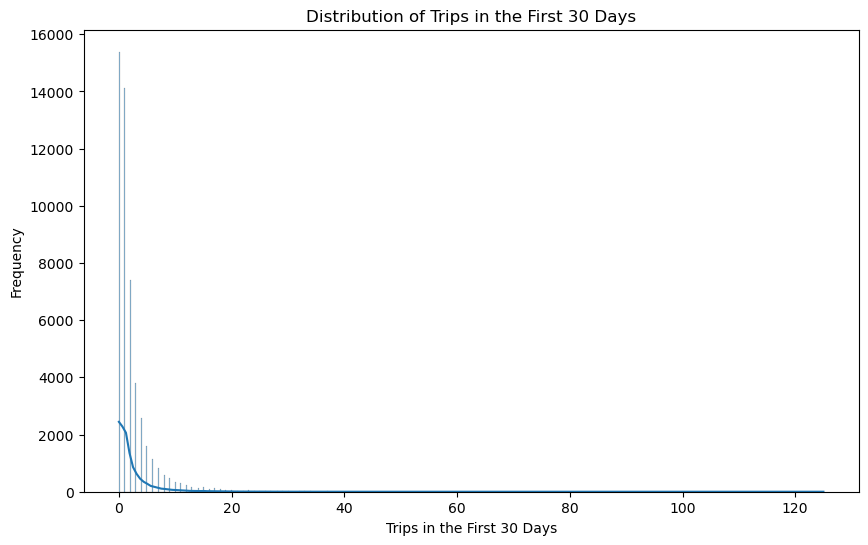

In [43]:
# Distribution of the first 30 days
plt.figure(figsize=(10,6))
sns.histplot(df['trips_in_first_30_days'], kde=True)
plt.title('Distribution of Trips in the First 30 Days')
plt.xlabel('Trips in the First 30 Days')
plt.ylabel('Frequency')
plt.show()

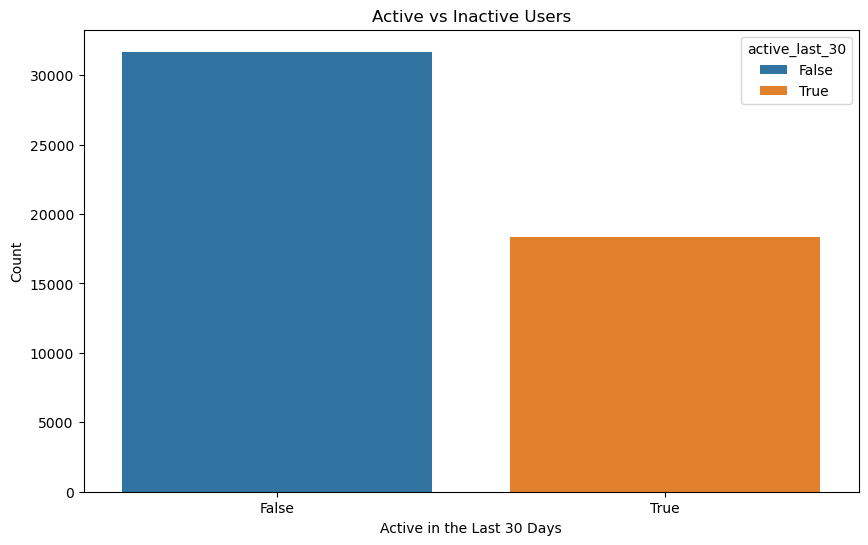

In [44]:
# Active vs Inactive Users
plt.figure(figsize=(10,6))
sns.countplot(x='active_last_30', data=df, hue='active_last_30')
plt.title('Active vs Inactive Users')
plt.xlabel('Active in the Last 30 Days')
plt.ylabel('Count')
plt.show()

Almost half of the users have become inactive in the last 30 days.

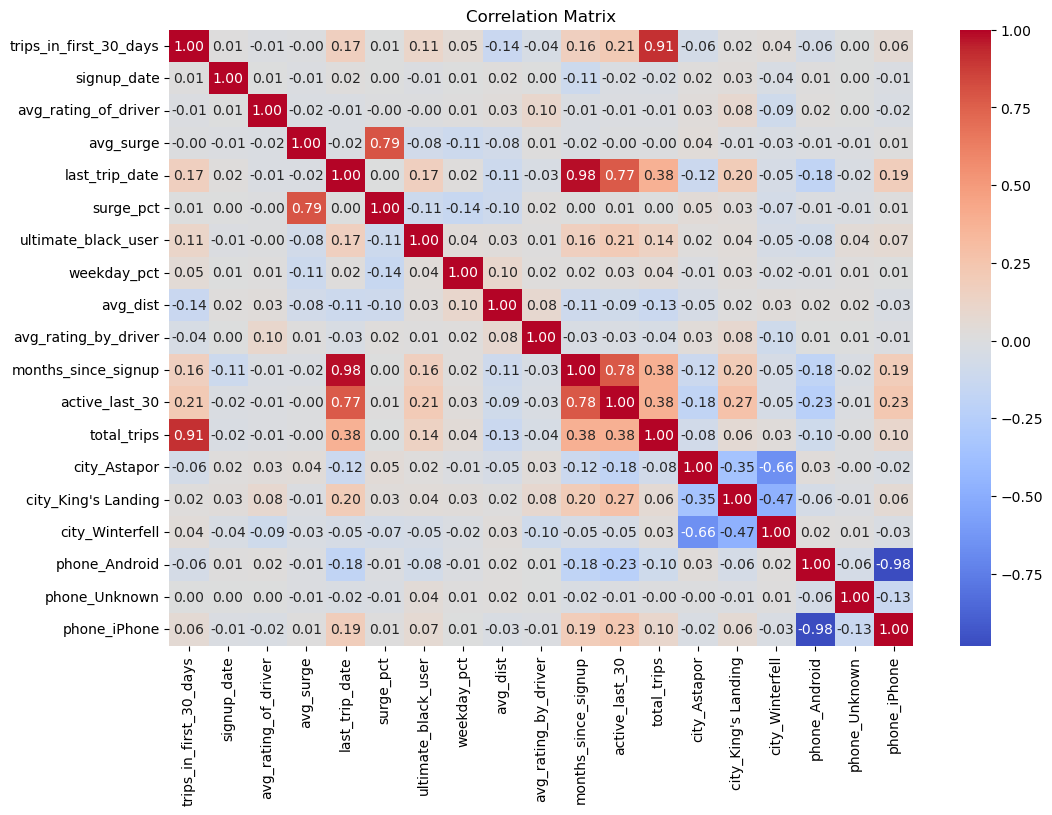

In [46]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

From the heatmap, we can find strong correlations:
* the last trip date and months since sign up has a high correlation, indicating that those who have been using Ultimate longer tend to have more recent trips
* users who have taken more trips are most likely to be active in the last 30 days

### Preprocessing and Model Training

In [49]:
# Train-test split data
X = df.drop(columns=['active_last_30', 'signup_date', 'last_trip_date'])
y = df['active_last_30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Trying out Logistic Regression Model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [51]:
# Trying out Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [52]:
# Trying out Gradient Boosting Model
gb = GradientBoostingClassifier(n_estimators=200, random_state=42, validation_fraction=0.1, n_iter_no_change=10)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [53]:
# Let's evaluate all models
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Randome Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Gradient Boosting Accuracy:', accuracy_score(y_test, y_pred_gb))

print('\nLogistic Regression Report:\n', classification_report(y_test, y_pred_lr))
print('\nRandom Forest Classification Report:\n', classification_report(y_test, y_pred_rf))
print('\nGradient Boosting Classification Report:\n', classification_report(y_test, y_pred_gb))

Logistic Regression Accuracy: 0.9366
Randome Forest Accuracy: 0.9293
Gradient Boosting Accuracy: 0.9379

Logistic Regression Report:
               precision    recall  f1-score   support

       False       0.95      0.95      0.95      6322
        True       0.91      0.92      0.91      3678

    accuracy                           0.94     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.94      0.94      0.94     10000


Random Forest Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.94      0.94      6322
        True       0.90      0.91      0.90      3678

    accuracy                           0.93     10000
   macro avg       0.92      0.93      0.92     10000
weighted avg       0.93      0.93      0.93     10000


Gradient Boosting Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.94      0.95      6322
        True       0.

In [54]:
# Use cross-validation to ensure model does not over or underfit the data
print('Logistic Regression Cross-Validation Score:', cross_val_score(lr, X, y, cv=5, scoring='accuracy').mean())
print('Randome Cross-Validation Score:', cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean())
print('Gradient Cross-Validation Score:', cross_val_score(gb, X, y, cv=5, scoring='accuracy').mean())

Logistic Regression Cross-Validation Score: 0.9381999999999999
Randome Cross-Validation Score: 0.9319200000000001
Gradient Cross-Validation Score: 0.93954


The best predictive model to use for this dataset for rider retention is the Gradient Boosting Model. Gradient Boosting has the highest accuracy, precision for False/non-active riders, and cross-validation score at 0.94. The second best model to use is the Logistic Regression with a cross-validation score of 0.938.

### Insight Suggestions for Rider Retention


In [97]:
# Use gradient boosting model to find important features
imp_features = gb.feature_importances_
imp_features_df = pd.DataFrame({'feature': X.columns, 'importance': imp_features})
imp_features_df = imp_features_df.sort_values(by='importance', ascending=False)
imp_features_df.head()

,feature,importance
8,months_since_signup,0.951593
11,city_King's Landing,0.016614
13,phone_Android,0.011279
4,ultimate_black_user,0.008896
9,total_trips,0.004447


According to the Importance Features, Ultimate can improve long-term rider retention through the following:

1. Assign incentives such as discounts for riders who have been loyal costumers since sign up
2. Invest in expanding marketing efforts in cities similar to King's Landing
3. Since there are more Android users, perhaps improve the app usage
4. Provide exclusive benefits or perks for users who are Ultimate Black users
5. Offer incentives to users based on a certain number of trips taken within a month